# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. Для оценки модели необходимо использовать RMSE. Модель должна показать значение RMSE < 2500.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Библиотеки и настройки

In [1]:
# импорты из стандартной библиотеки
import os
import warnings

# импорты сторонних библиотек
import numpy as np
import pandas as pd
 

# импорты модулей текущего проекта
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    cross_val_score
)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm  import LGBMRegressor

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.metrics import (
    mean_squared_error, 
    r2_score,
    make_scorer
)

from sklearn.dummy import DummyRegressor

from datetime import datetime
import time

# настройки
warnings.filterwarnings("ignore")

# константы 
RANDOM_STATE = 0

## Подготовка данных

### Загрузка данных и первичный осмотр

In [2]:
path = '/datasets/autos.csv'

if os.path.exists(path):
    data = pd.read_csv(path)
else:
    print('Ошибка в считывании данных')

In [3]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Описание данных:**

Признаки:

 - DateCrawled — дата скачивания анкеты из базы
 - VehicleType — тип автомобильного кузова
 - RegistrationYear — год регистрации автомобиля
 - Gearbox — тип коробки передач
 - Power — мощность (л. с.)
 - Model — модель автомобиля
 - Kilometer — пробег (км)
 - RegistrationMonth — месяц регистрации автомобиля
 - FuelType — тип топлива
 - Brand — марка автомобиля
 - Repaired — была машина в ремонте или нет
 - DateCreated — дата создания анкеты
 - NumberOfPictures — количество фотографий автомобиля
 - PostalCode — почтовый индекс владельца анкеты (пользователя)
 - LastSeen — дата последней активности пользователя
 
Целевой признак
 - Price — цена (евро)

### Удаление неинформативных признаков

Очевидно, что признаки `DateCrawled`, `RegistrationMonth`, `RegistrationMonth`, `DateCreated`, `PostalCode`, `LastSeen`,`NumberOfPictures` неинформативны: чать из них является информацией об анкете/пользователе, а часть не влияет на цену автомобиля - удалим их.

In [4]:
clean_data = data.drop(['DateCrawled', 'RegistrationMonth', 'DateCreated', 'PostalCode', 'LastSeen', 'NumberOfPictures'], axis=1)
clean_data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


### Приведение названий колонок к snake_case

In [5]:
clean_data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

In [6]:
clean_data = clean_data.rename(columns={'Price':'price', 'VehicleType':'vehicle_type', 'RegistrationYear':'registration_year', 
                           'Gearbox':'gearbox', 'Power':'power', 'Model':'model', 'Kilometer':'kilometer', 
                           'FuelType':'fuel_type', 'Brand':'brand', 'Repaired':'repaired'})

### Анализ данных и работа с выбросами

In [7]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


В выборке более 354 тысяч объектов. Признаки либо целочисленнные, либо категориальные. В некоторых колонках есть пропуски.

Разделим признаки на количественные и категориальные для дальнейшего удобства.

In [8]:
categorical = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']
numerical = list(set(clean_data.columns) - set(categorical))

In [9]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354369 non-null  int64 
 1   vehicle_type       316879 non-null  object
 2   registration_year  354369 non-null  int64 
 3   gearbox            334536 non-null  object
 4   power              354369 non-null  int64 
 5   model              334664 non-null  object
 6   kilometer          354369 non-null  int64 
 7   fuel_type          321474 non-null  object
 8   brand              354369 non-null  object
 9   repaired           283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB


Оценим количественные признаки статистически.

In [10]:
clean_data.describe()

,price,registration_year,power,kilometer
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535
std,4514.158514,90.227958,189.850405,37905.341530
min,0.000000,1000.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6400.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


Похоже, что в признаках `price`, `registration_year`, `power` есть выбросы. Рассмотрим их подробнее.

array([[<AxesSubplot:title={'center':'price'}>,
        <AxesSubplot:title={'center':'registration_year'}>],
       [<AxesSubplot:title={'center':'power'}>,
        <AxesSubplot:title={'center':'kilometer'}>]], dtype=object)

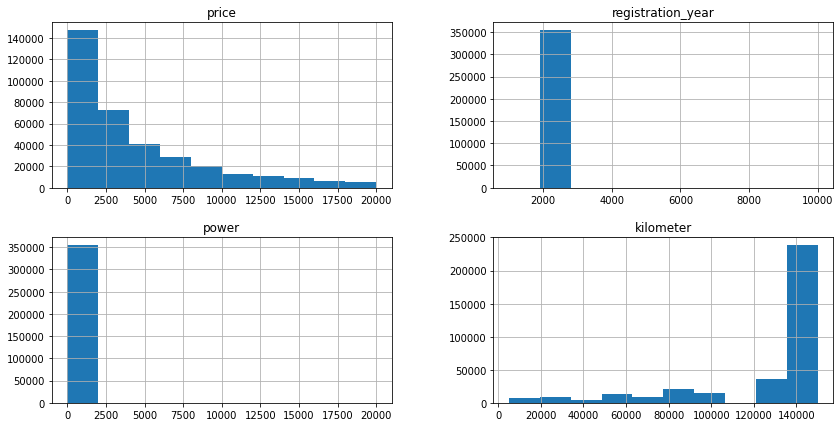

In [11]:
clean_data.hist(figsize=(14, 7))

Распределение признака `price` показывает, что в нём могут быть занчения, близкие к нулю. Рассмотрим этот признак подробнее. 

<AxesSubplot:>

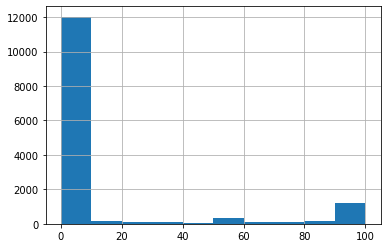

In [12]:
clean_data['price'].hist(range=(0, 100))

In [13]:
clean_data.loc[clean_data['price']<1, 'price'].count()

10772

In [14]:
clean_data.loc[clean_data['price']<50, 'price'].count()

12423

In [15]:
clean_data.loc[clean_data['price']<100, 'price'].count()

13314

Действительно у некоторых объектов есть аномально низкие цены - ниже 100. Их количество составляет около 4% выборки - ими можно принебречь.

In [16]:
clean_data_v2 = clean_data.loc[clean_data['price'] > 100].copy()

Рассмотрим подробнее признак `registration_year`. Заметим, что максимальный год регистрации не может быть больше года максимальной даты скачивания анкеты.

<AxesSubplot:>

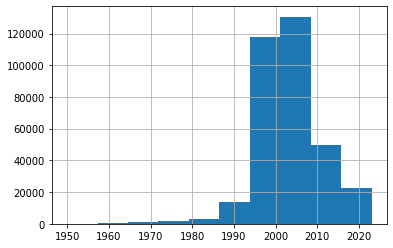

In [17]:
clean_data_v2['registration_year'].hist(range=(1950, 2023))

In [18]:
clean_data_v2.loc[(clean_data['registration_year'] < 1970) | \
               (clean_data['registration_year'] > pd.to_datetime(data['DateCrawled'].max()).year),\
               'registration_year'].count()

14784

Удалим объекты с годом регистрации меньше 1970 и больше года максимальной даты скачивания анкеты.

In [19]:
clean_data_v3 = clean_data_v2.loc[
    ~(
        (clean_data['registration_year'] < 1970) | \
        (clean_data['registration_year'] > pd.to_datetime(data['DateCrawled'].max()).year)
    )
].copy()
clean_data_v3.shape[0]

325240

Рассмотрим подробнее признак `power`.

<AxesSubplot:>

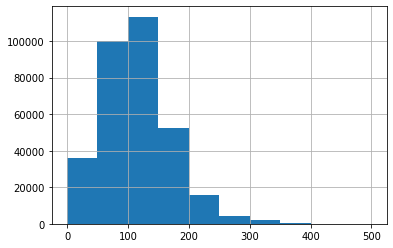

In [20]:
clean_data_v3['power'].hist(range=(0, 500))

In [21]:
clean_data_v3.loc[clean_data['power'] > 400, 'power'].count()

641

In [22]:
clean_data_v3.loc[clean_data['power'] < 100, 'power'].count()

135817

Удалим объекты c мощьностью выше 500. Подозрение вызывают машины с мощьностью ниже 100, но они составляют больше 30% выборки, поэтому считать их выбросами нельзя. Возможно, продаются машины с проблемными двигателями.

In [23]:
clean_data_v4 = clean_data_v3.loc[clean_data_v3['power'] <= 500].copy()

In [24]:
clean_data_v4.shape[0]

324859

Рассмотрим корреляцию между количесвтенными признаками.

In [25]:
clean_data_v4.corr()

,price,registration_year,power,kilometer
price,1.000000,0.492674,0.492859,-0.365240
registration_year,0.492674,1.000000,0.147249,-0.278975
power,0.492859,0.147249,1.000000,0.074792
kilometer,-0.365240,-0.278975,0.074792,1.000000


Между признаками нет сильной корреляции.

### Работа с пропусками и дубликатами

In [26]:
clean_data_v4.duplicated().sum()

42020

В получившейся выборке очень много дубликатов. Скорее всего, она образовались из-за удаления не информативных для задачи столбцов. Проверим это.

In [27]:
data.duplicated().sum()

4

Удалим из подготовленной выборки полные дубликаты из начальной.

In [28]:
clean_data_v5 = clean_data_v4.loc[~data.duplicated()].copy()

Посчитаем количество пропусков в разных столбцах.

In [29]:
clean_data_v5.isna().sum()

price                    0
vehicle_type         18436
registration_year        0
gearbox              14146
power                    0
model                14648
kilometer                0
fuel_type            22520
brand                    0
repaired             57496
dtype: int64

Все признаки с пропусками являются категориальными. Явной зависимости между данными признаками и другими нет. Строк с пропусками достаточно много, поэтому удалить их нельзя. Следует вынести их в отдельную категорию. Заполним проgуски строкой "NA" (нет данных).

In [30]:
clean_data_v6 = clean_data_v5.fillna('NA').copy()
clean_data_v6.isna().sum()

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Тип категориальных признаков изменим с `object` на `catgory` для дальнейшего удобства работы (c LGBMRegressor).

In [31]:
final_data = clean_data_v6.copy()
final_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,NA,1993,manual,0,golf,150000,petrol,volkswagen,NA
1,18300,coupe,2011,manual,190,NA,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NA
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


<div class="alert alert-block alert-success">
<b>✔️ Успех:</b>

Пропуски успешно заполнены 👍 Модели теперь не будут капризничать)
</div>

### Вывод

В ходе предобработки
 - данные были загружены и просмотрены;
 - из данных были удалены неинформативные признаки;
 - данные были проанализированы, на основе чего были удалены выбросы;
 - были заполнены пропуски в данных.

## Обучение и анализ моделей

Разделим исходную выборку на признаки и целевой признак, а также на обучающую, валидационную и тестовую выборки.

In [32]:
features = final_data.drop(['price'], axis=1)
target = final_data['price'].loc[features.index]

features_train, features_test, target_train, target_test = train_test_split(features, 
                                                                            target, 
                                                                            test_size=0.25, 
                                                                            random_state=RANDOM_STATE)

In [33]:
numerical.remove('price')

Для обучения выберем следующие модели: LGBMRegressor, RandomForestRegressor, LinearRegresson. 
С помощью пайплайна подготовим данные так, чтобы они подходили для трёх выбранных моделей, а также подберём оптимальные гиперпараметры и оценим качество моделей с помощью кросс-валидации. 

Напишем обработчики колонок для каждой модели. Модель LGBMRegressor умеет работать с категориальными признаками, поэтому нужно только масштабировать количественные признаки. Для RandomForestRegressor дополнительно используем порядковое кодирование категориальных признаков. Для LinearRegresson преобразуем категориальные признаки с помощью OHE.

In [34]:
col_transformer_lgbmr = make_column_transformer(
    (
        StandardScaler(), 
        numerical
    )
)

col_transformer_tree = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown='ignore'), 
        categorical
    ),
    (
        StandardScaler(), 
        numerical
    )
)

col_transformer_linear = make_column_transformer(
    (
        OneHotEncoder(handle_unknown='ignore'), 
        categorical
    ),
    (
        StandardScaler(), 
        numerical
    )
)

### Подбор оптимальных гиперпараметров

In [35]:
models = [
    LGBMRegressor(random_state=RANDOM_STATE),
    RandomForestRegressor(random_state=RANDOM_STATE),
    LinearRegression()
]
optimal_models = []
params = [
    {
        'lgbmregressor__max_depth': range(1, 10),
        'lgbmregressor__n_estimators': range(10, 210, 50)
    },
    {
        'randomforestregressor__max_depth': range(1, 10),
        'randomforestregressor__n_estimators': range(10, 210, 50)    
    },
    {
   
    }    
]
transformers = [
    col_transformer_lgbmr,
    col_transformer_tree,
    col_transformer_linear  
]
for i in range(len(models)):
    
    pipeline = make_pipeline(
                    transformers[i],
                    models[i]
                )
    
    model = RandomizedSearchCV(
                pipeline, 
                param_distributions=params[i],
                scoring='neg_root_mean_squared_error', 
                cv=5,
                random_state=RANDOM_STATE,
                n_jobs=-1
                )
    
    optimal_models.append(model.fit(features_train, target_train))
    model_opt_best_score = optimal_models[i].best_score_
    model_opt_best_params = optimal_models[i].best_params_



    print()
    print(models[i],':')
    print(f'\t\tлучшее значение RMSE: {model_opt_best_score: .0f}')
    print(f'\t\tлучшие параметры: {model_opt_best_params}')


LGBMRegressor(random_state=0) :
		лучшее значение RMSE: -2078
		лучшие параметры: {'lgbmregressor__n_estimators': 160, 'lgbmregressor__max_depth': 8}

RandomForestRegressor(random_state=0) :
		лучшее значение RMSE: -2049
		лучшие параметры: {'randomforestregressor__n_estimators': 160, 'randomforestregressor__max_depth': 8}

LinearRegression() :
		лучшее значение RMSE: -2606
		лучшие параметры: {}


In [36]:
optimal_models[0].cv_results_

{'mean_fit_time': array([397.44904571,  13.55337782,  13.94269514, 194.73265309,
        180.57413054,  48.66711626,  17.43534703,  10.47326479,
         27.81579709,  22.78081422]),
 'std_fit_time': array([53.23814766,  1.32960075,  4.70005024, 25.68615498, 15.93577504,
        27.01208673,  3.51470729,  3.65761845,  5.71953977, 13.57510195]),
 'mean_score_time': array([0.48691635, 0.08359566, 0.09166331, 0.37496133, 0.36495695,
        0.44053025, 0.30095048, 0.18161001, 0.3835331 , 0.2741159 ]),
 'std_score_time': array([0.02693962, 0.02489344, 0.00617183, 0.03050193, 0.03114181,
        0.04264293, 0.00500941, 0.03600187, 0.03244819, 0.03591693]),
 'param_lgbmregressor__n_estimators': masked_array(data=[160, 10, 10, 110, 110, 160, 110, 110, 160, 60],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_lgbmregressor__max_depth': masked_array(data=[8, 6, 5, 8, 6, 4, 

### Обучение и анализ моделей

Обучим модели с оптимальными гиперпараметрами, измерим качество модели с помощью кросс-валидации, а также время обучения и время предсказания.

In [55]:
models = [
    LGBMRegressor(random_state=RANDOM_STATE, n_estimators=160, max_depth=8),
    RandomForestRegressor(random_state=RANDOM_STATE, n_estimators=160, max_depth=8),
    LinearRegression()
]
transformers = [
    col_transformer_lgbmr,
    col_transformer_tree,
    col_transformer_linear  
]
optimal_models = []

for i in range(len(models)):
    
    pipeline = make_pipeline(
                    transformers[i],
                    models[i]
                )
    
    score = cross_val_score(pipeline, features_train, target_train, cv=5, scoring='neg_root_mean_squared_error').mean() * -1
    fitting_start_time = time.time()
    optimal_models.append(pipeline.fit(features_train, target_train))
    fitting_end_time = time.time()
    predict = pipeline.predict(features_train)
    prediction_end_time = time.time()
    



    print()
    print(models[i],':')
    print(f'\t\tСреднее RMSE при кросс-валидации: {score: .0f}')
    print(f'\t\tВремя обучения: {fitting_end_time - fitting_start_time: .2f}')
    print(f'\t\tВремя предсказания: {prediction_end_time - fitting_end_time: .2f}')


LGBMRegressor(max_depth=8, n_estimators=160, random_state=0) :
		Среднее RMSE при кросс-валидации:  2078
		Время обучения:  4.70
		Время предсказания:  2.32

RandomForestRegressor(max_depth=8, n_estimators=160, random_state=0) :
		Среднее RMSE при кросс-валидации:  2049
		Время обучения:  49.71
		Время предсказания:  2.53

LinearRegression() :
		Среднее RMSE при кросс-валидации:  2606
		Время обучения:  37.85
		Время предсказания:  0.54


LinearRegression даёт слишком большое значение RMSE, поэтому использовать эту модель для решения поставленной задачи не стоит. LGBMRegressor показывает значение RMSE незначительно больше RandomForestRegressor. При этом время обучения первой модели в 10 раз меньше времени обучения второй, что является существенным преимуществом. Также время предсказания - меньше на 10%.
    
Всвязи с этим для решения поставленной задачи рекомендуется использовать модель **LGBMRegressor с гиперпараметрами `max_depth=8`, `n_estimators=160` и `random_state=0`**. 

### Вывод

В ходе данного этапа
 - данные были подготовлены для обучения;
 - были выявлены оптимальные гиперпарметры для модели LGBMRegressor и RandomForestRegressor;
 - было проверено качество моделей LGBMRegressor, RandomForestRegressor и LinerRegression с помощью кросс-валидации;
 - были обучены модели с оптимальными гиперпараметрами;
 - было рассчитано качество моделей на тестовой выборке и измерено время обучения и предсказания в секундах:

|N|модель|RMSE|время обучения|время предсказания|
|:-|:-|:-|:-|:-|
|1|LGBMRegressor|2078|4.68|2.22|
|2|RandomForestRegressor|2049|47.27|2.54|
|3|LinearRegression|2606|36.25|0.49|

 - на основании полученных данных была вынесена рекомендация использовать для решения задачи модель **LGBMRegressor с гиперпараметрами `n_estimators=160` и `max_depth=8`**.

## Тестирование рекомендованной модели

### Оценка качества на тестовой выборке

Узнаем качество LGBMRegressor на тестовой выборке и время предсказания.

In [57]:
final_model = make_pipeline(transformers[0], models[0])
predict = final_model.predict(features_test)
    
score = mean_squared_error(predict, target_test, squared=False)
    
print(f'Значение RMSE на тестовой выборке: {score: .0f}')

Значение RMSE на тестовой выборке:  2069


Значение RMSE меньше 2500, что удовлетворяет условиям задачи.

### Проверка на адекватность

Для проверки на адекватность обучим dummy-модель.

In [58]:
dummy = DummyRegressor()

dummy_pipeline = make_pipeline(
                 col_transformer_tree,
                 dummy
                 )
dummy_pipeline.fit(features_train, target_train)
predict = dummy_pipeline.predict(features_test)

score = mean_squared_error(predict, target_test, squared=False)

print(f'Качество dummy-модели на тествой выборке: {score:.0f}' )

Качество dummy-модели на тествой выборке: 4535


Dummy-модель значительно хуже рекомендуемой - значит, применение рекомендуемой модели адекватно.

### Вывод 

В ходе данного этапа
 - была проведена оценка рекомендуемой модели на тестовой выборке, RMSE оказалось меньше 2500, что удовлетворяет условиям задачи;
 - для провекри на адекватность была обучена dummy-модель, RMSE которой оказалось более 4500 - была подтверждена адекватность использования рекомендуемой модели.

## Общий вывод

В ходе работы
- была проведена предобработка данных:
  - данные были загружены и просмотрены;
  - из данных были удалены неинформативные признаки;
  - данные были проанализированы, на основе чего были удалены выбросы;
  - были заполнены пропуски в данных;
- были обучены модели и проанализированы модели для решения задачи:
   - данные были подготовлены для обучения;
   - были выявлены оптимальные гиперпарметры для модели LGBMRegressor и RandomForestRegressor;
   - было проверено качество моделей LGBMRegressor, RandomForestRegressor и LinerRegression с помощью кросс-валидации;
   - были обучены модели с оптимальными гиперпараметрами;
   - было рассчитано качество моделей на тестовой выборке и измерено время обучения и предсказания в секундах:

|N|модель|RMSE|время обучения|время предсказания|
|:-|:-|:-|:-|:-|
|1|LGBMRegressor|2078|4.68|2.22|
|2|RandomForestRegressor|2049|47.27|2.54|
|3|LinearRegression|2606|36.25|0.49|

- на основании полученных данных была вынесена рекомендация использовать для решения задачи модель **LGBMRegressor с гиперпараметрами `n_estimators=160` и `max_depth=8`**;
- было проведено тестирование рекомендованной модели:
    - была проведена оценка рекомендуемой модели на тестовой выборке, RMSE оказалось меньше 2500, что удовлетворяет условиям задачи;
    - для провекри на адекватность была обучена dummy-модель, RMSE которой оказалось более 4500 - была подтверждена адекватность использования рекомендуемой модели. 